### Load data

/var/folders/t8/0vpf6dyn0q111yjvx8dbs7dc0000gn/T/ipykernel_40914/3009698167.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.mean())


SR Evidence          0.666667
bias_highbaserate    0.437500
pre_map_change       0.708333
post_map_change      0.541667
twostep_planning     0.708333
dtype: float64
12
0     2
1     2
2     4
3     2
4     3
5     2
6     3
7     2
8     4
9     2
10    4
11    4
Name: twostep_planning, dtype: int64

percent choices consistent with SR = 0.13793103448275862
[0.5  0.   0.75 1.   0.25]


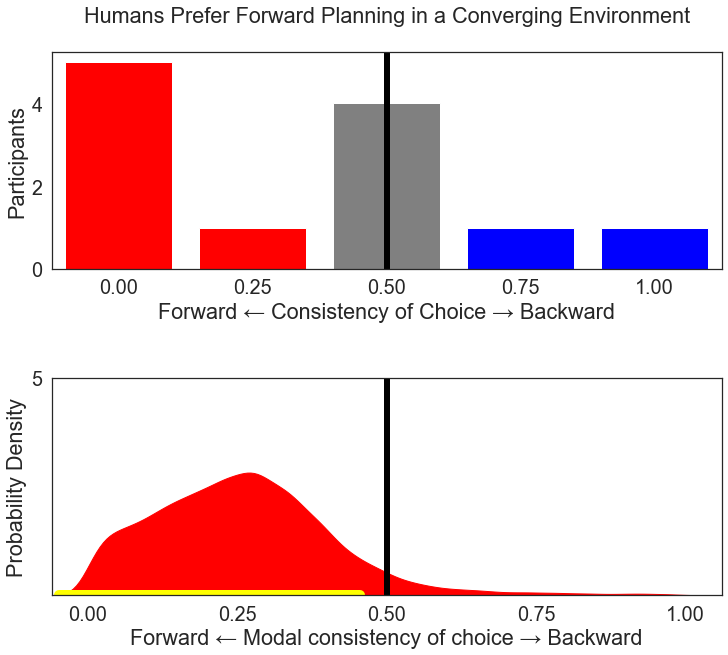

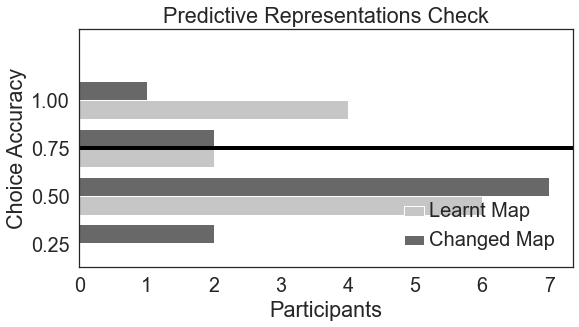

ROPE of PR EVIDENCE: 0.0342672208421171


In [18]:
# load dependencies
import numpy as np
from IPython.display import Image
from matplotlib import gridspec

import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure


import os

df=pd.read_csv('all_planning_questions_baseratebias.csv') #load data
#print means of each key variable
print(df.mean())
print(len(df))
n_subjects=len(df)
#Convert percentage of each key variable to number of successes out of 8 choices
#The purpose of this is to transform the data such that it can be modelled by a binomial likelihood
rr_map=round(df['pre_map_change']*4,2)
rr_map = rr_map.astype(int)

tr_changed_map=round(df['post_map_change']*4,2)
tr_changed_map = tr_changed_map.astype(int)

br_bias=round(df['bias_highbaserate']*4,2)
br_bias = br_bias.astype(int)

twostep_planning=round(df['twostep_planning']*4,2)
twostep_planning = twostep_planning.astype(int)
print(twostep_planning)
print('')

PR_evidence=round((1-df['SR Evidence'])*4,2)
PR_evidence = PR_evidence.astype(int)
SR_evidence=4-PR_evidence

print('percent choices consistent with SR = {}'.format(SR_evidence.sum()/(4*58)))

df['SR Evidence']=1-(df['SR Evidence'])
br_bias=df['bias_highbaserate']*4
# action_bias=df['bias_left_side']*8
print(df['SR Evidence'].unique())

sns.set(style='white', font='arial', font_scale=1.8, rc={'figure.figsize':(12,10)})


fig, axes = plt.subplots(2, 1)

x=sns.countplot(x="SR Evidence", palette='Blues',data=df,ax=axes[0],order = [x/4 for x in range(0,5)])

y=sns.kdeplot(data=df_posterior, x=('posterior', 'omega'),ax=axes[1],fill=True,alpha=1,color='red')
axes[0].set_ylabel('Participants')
axes[0].bar(df["SR Evidence"].unique()*4, df["SR Evidence"].value_counts(sort=False), color=['gray', 'red', 'blue', 'blue', 'red'])
axes[0].set_xlabel('Forward \u2190 Consistency of Choice \u2192 Backward')
axes[0].set_xlim(-0.5, 4.5)
# axes[0].xaxis.set_major_formatter('{x:.1f}')
axes[0].set_title('Humans Prefer Forward Planning in a Converging Environment\n')

axes[0].axvline(2,color='black',linewidth=6.0)
axes[1].set_xlim(-0.06,1.06)
axes[1].set_ylim
axes[1].set_ylabel('Probability Density')
axes[1].set_xlabel('Forward \u2190 Modal consistency of choice \u2192 Backward')
axes[1].axvline(0.5,color='black',linewidth=6.0)
axes[1].axhline(y=0,xmin=0.01,xmax=0.46,color='yellow',linewidth=10.0)
plt.sca(axes[1])
plt.yticks([5])
plt.xticks([0,0.25,0.5,0.75,1])
axes[0].margins(x=0)
axes[1].margins(x=0)
axes[0].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes[0].get_xticklabels()])

# axes[1].set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in axes[1].get_xticklabels()])

fig.subplots_adjust(hspace=0.5)


plt.savefig('study3_PRevidence.png',dpi=300)

plt.show()

sns.set(style='white', font='arial', font_scale=1.8, rc={'figure.figsize':(8.5,5)})
fig, ax = plt.subplots()
#sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


#load data
df_new=pd.DataFrame()
df_new['Revaluation Score']=df['pre_map_change'].values.tolist()+df['post_map_change'].values.tolist()
df_new['']=['Learnt Map']*len(df)+['Changed Map']*len(df)                              
#plot transition revaluation performance

ax=sns.countplot(data=df_new, y="Revaluation Score",hue="",palette='Greys',orient='v')
plt.xlabel('Participants')

ax.set_ylim(-0.5,4.5)
ax.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])

plt.axhline(2,color='black',linewidth=4.0)
sns.move_legend(ax, "lower right",frameon=False)

# Change the font size of the legend text
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_fontsize(20)

# Change the size and spacing of the legend bars
for patch in leg.get_patches():
    patch.set_height(10)
    patch.set_width(20)
    patch.set_x(patch.get_x() + 30) # adjust the y position of the bars


# for tick in ax.get_xaxis().get_major_ticks():
#     tick.set_pad(8.)

plt.ylabel('Choice Accuracy')
plt.title('Predictive Representations Check')

plt.tight_layout()

plt.savefig('study3_tr_Reval.png',dpi=300)
plt.show()
# Print 0.1*SD of PR Evidence to define the ROPE
print('ROPE of PR EVIDENCE: {}'.format(0.1*df['SR Evidence'].std()))


# Fit Model for Hypothesis 1: Evidence for PR-based Planning

Below we fit the beta-binomial described in text to choice data for Variable 1, which defines the number of times participants chose in line with PR-based planning. If omega, the mode of the group distribution, is estimated to be significantly greater than 0.5 (no evidence of PR-based planning), then we conclude evidence for our main hypothesis.

We followed Kruschke’s (2014) guidelines to derive the ROPE, wherein we took the standard deviation of the percentage of times subjects chose in line with PR-based planning and multiplied this value by 0.1 , which was 0.18, and multiplied this by 0.1, to define effects that are too small to be considered significant. We then rounded this up to 0.2 to make it even a bit more conservative than Kruschke’s (2014) recommendation. We use this ROPE for all subsequent analyses.

Note below, we fit the same model to the two subsequent manipulation checks, except include different variables (specifically, variables 3 and 5 as described in the preregistration).

In [2]:
n_subjects = n_subjects
subjects= [*range(n_subjects)]
with pm.Model() as hierarchical_model:

    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=PR_evidence) 
    
with hierarchical_model:
    trace_main = pm.sample(draws=4000, target_accept=0.9999)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 197 seconds.


In [3]:
df_posterior=trace_main.to_dataframe()
df_posterior.to_csv('posterior_model.csv')

In [4]:
import arviz as az
az.summary(trace_main, ['omega'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.258,0.149,0.0,0.486,0.002,0.001,5771.0,6374.0,1.0


In [5]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=twostep_planning) 
with hierarchical_model:
    twostep_trace = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 103 seconds.


In [7]:
import arviz as az
az.summary(twostep_trace,['omega'],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.751,0.104,0.567,0.967,0.002,0.001,3786.0,4905.0,1.0


In [18]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    alpha = pm.Gamma('alpha', 1.105125 , 0.1051249)
    beta = pm.Gamma('beta', 1.105125 , 0.1051249)
    
    theta = pm.Beta('theta', alpha=alpha+1, beta=beta+1, shape=n_subjects)

    y = pm.Binomial('y',n=4,p=theta[subjects], observed=rr_map) 
    
with hierarchical_model:
    trace_pre_map = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 130 seconds.


In [19]:
import arviz as az
mean_rr=trace_pre_map.posterior.alpha.values/(trace_pre_map.posterior.alpha.values+trace_pre_map.posterior.beta.values)
az.summary(mean_rr,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.71,0.135,0.489,0.995,0.002,0.001,5159.0,6315.0,1.0


## Posterior distribution for group-level tendency to choose in line with PR-based planning

As you see below, the parameter omega defining the group-level tendency to choose in line with PR-based planning was significantly greater than the null value of 0.5. Specifically, the posterior highest density interval does not contain any values in the pre-defined region of practical equivalence, defining values similar-enough to 0.5 to be considered null effect sizes. 

# Fit model for manipulation check 1: Bias for high base-rate action?

In [8]:
n_subjects = n_subjects
subjects= [*range(n_subjects)]
with pm.Model() as hierarchical_model:

    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)


    y = pm.Binomial('y',n=4,p=theta[subjects], observed=br_bias) 
    
with hierarchical_model:
    trace = pm.sample(draws=4000, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 101 seconds.


In [9]:
df_posterior_distal=trace.to_dataframe()

## Plot posterior for omega: The highest-density interval (yellow line) in the posterior
Manipulation check passed!

In [10]:
az.summary(trace, ['omega'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.428,0.114,0.215,0.645,0.002,0.001,4886.0,5017.0,1.0


/var/folders/t8/0vpf6dyn0q111yjvx8dbs7dc0000gn/T/ipykernel_40914/3632826102.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])


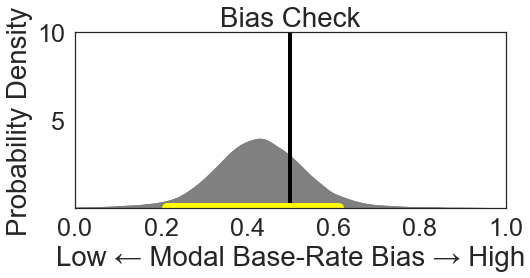

In [11]:
sns.set(style='white', font='arial', font_scale=2.3, rc={'figure.figsize':(8,4.5)})
fig, ax = plt.subplots()

x=sns.kdeplot(data=df_posterior_distal, x=('posterior', 'omega'),fill=True,alpha=1,color="gray")

y=sns.kdeplot(data=df_posterior_distal, x=('posterior', 'omega'),fill=True,alpha=1,color="gray")
ax.set_ylabel('Probability Density')
ax.set_xlabel('Low \u2190 Modal Base-Rate Bias \u2192 High')
ax.set_xlim(0,1.0)
ax.set_yticks([5,10])

ax.axvline(0.5,color='black',linewidth=4.0)

ax.set_title('Bias Check')
ax.axhline(y=0,xmin=0.213,xmax=0.613,color='yellow',linewidth=10.0)



ax.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])

plt.tight_layout()

plt.savefig('study3_action_baseratebias.png',dpi=300)
plt.show()

# Performance post map change

In [51]:
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    alpha = pm.Gamma('alpha', 1.01 , 0.01)
    beta = pm.Gamma('beta', 1.01 , 0.01)
    
    theta = pm.Beta('theta', alpha=alpha+1, beta=beta+1, shape=n_subjects)

    y = pm.Binomial('y',n=4,p=theta[subjects], observed=tr_changed_map) 
    
with hierarchical_model:
    trace_changed_map = pm.sample(draws=4000, target_accept=0.99,init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 94 seconds.


In [52]:
import arviz as az
mean_tr=(trace_changed_map.posterior.alpha.values)/(trace_changed_map.posterior.alpha.values+trace_changed_map.posterior.beta.values)
az.summary(mean_tr,hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.168,0.107,0.0,0.351,0.001,0.001,6985.0,8088.0,1.0


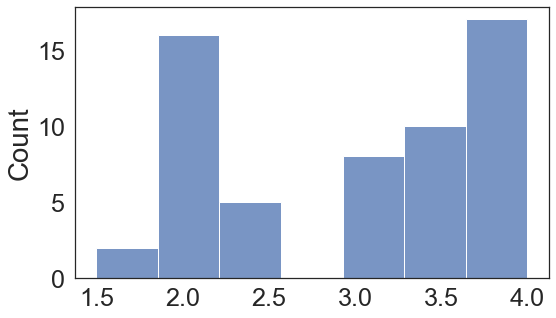

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 134 seconds.


In [53]:
difference_reval=(((rr_map-tr_changed_map))+4.0)/2.0
sns.histplot(difference_reval)
plt.show()
subjects= [*range(n_subjects)]

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 1.105125 , 0.1051249)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_subjects)
    y = pm.Binomial('y',n=4,p=theta[subjects], observed=difference_reval) 
    
with hierarchical_model:
    diff_reval = pm.sample(draws=4000, target_accept=0.999,init='adapt_diag')

In [54]:
import arviz as az
# diff_tr=diff_reval.posterior.alpha.values/(diff_reval.posterior.alpha.values+diff_reval.posterior.beta.values)
az.summary(diff_reval,['omega'],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.747,0.045,0.663,0.835,0.001,0.001,1966.0,3151.0,1.0


In [24]:
successes=0 #number of times posterior did not include key value from ROPE
num_iterations=100
sample_size=65
for i in range(num_iterations): # fit model 300 times
    sample_omega=np.random.choice(trace_main.posterior.omega.values.flatten(), size=1)[0]
    sample_kappa=np.random.choice(trace_main.posterior.kappa.values.flatten(),size=1)[0]
    sample_alpha=sample_omega*(sample_kappa-2)+1
    sample_beta=(1-sample_omega)*(sample_kappa-2)+1

    thetas=np.random.beta(sample_alpha,sample_beta,sample_size)
    sample_data=[]
    for theta in thetas:
        sample_data.append(np.random.binomial(4,theta,1))
    subjects= [*range(sample_size)] 
    with pm.Model() as hierarchical_model:
        omega_s = pm.Beta('omega_s', 1., 1.)
        kappa_minus2_s = pm.Gamma('kappa_minus2_s', 1.105125 , 0.1051249, transform=None)
        kappa_s = pm.Deterministic('kappa_s', kappa_minus2_s + 2)

        theta_s = pm.Beta('theta_s', alpha=omega_s*(kappa_s-2)+1, beta=(1-omega_s)*(kappa_s-2)+1, shape=sample_size)

        y = pm.Binomial('y',n=4,p=theta_s[subjects], observed=sample_data) 

    with hierarchical_model:
        trace_s = pm.sample(draws=2000, target_accept=0.90,init='adapt_diag',progressbar = False)
    
    df_summary_s=az.summary(trace_s,var_names=['omega_s'],hdi_prob=0.95)
    if df_summary_s['hdi_2.5%'].values[0]<0.50:
        print('success')
        successes+=1
    else:
        print('failed')

bayesian_power=successes/num_iterations


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 77 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 82 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


failed


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 86 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.


failed


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


failed


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 62 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


failed


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 73 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 74 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 64 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_s, kappa_minus2_s, theta_s]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


success


In [25]:
bayesian_power

0.96